# Evaluation Metrics for Classification
In the previous session we trained a model for predicting churn. How do we know if it's good?

## 1- Evaluation metrics: session overview
Dataset: https://www.kaggle.com/blastchar/telco-customer-churn  
https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv  

Metric - function that compares the predictions with the actual values and outputs a single number that tells how good the predictions are

In [1]:
import pandas as pd
import numpy as np
np.set_printoptions(legacy='1.25')

import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
# !wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv

In [4]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [5]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [6]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [7]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [8]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8034066713981547

## 2- Accuracy and dummy model
* Evaluate the model on different thresholds
* Check the accuracy of dummy baselines

In [9]:
len(y_val)

1409

In [10]:
(y_val == churn_decision).sum()

1132

In [11]:
1132 / 1409

0.8034066713981547

Is churn threshold at 50% good or not?

In [12]:
from sklearn.metrics import accuracy_score

In [13]:
accuracy_score(y_val, y_pred >= 0.5)

0.8034066713981547

In [14]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


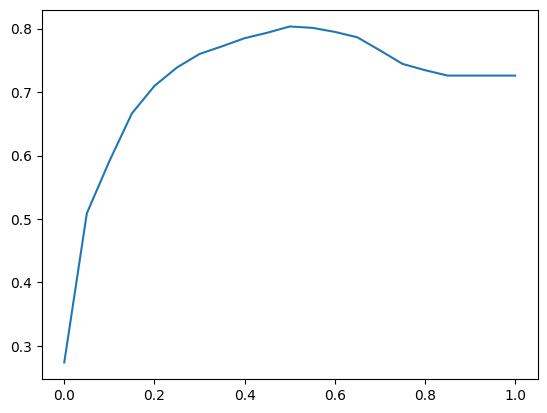

In [15]:
plt.plot(thresholds, scores)

We can change the decision threshold, it should not be always 0.5. But, in this particular problem, the best decision cutoff, associated with the hightest accuracy (80%), was indeed 0.5.

In [16]:
from collections import Counter

In [17]:
Counter(y_pred >= 1.0) # prediction that every custumers are not churning

Counter({False: 1409})

In [18]:
1 - y_val.mean()

0.7260468417317246

The dummy model for all customers not churning is 73% accurate

In [19]:
Counter(y_val)

Counter({0: 1023, 1: 386})

Note that if we build a dummy model in which the decision cutoff is 1, so the algorithm predicts that no clients will churn, the accuracy would be 73%. Thus, we can see that the improvement of the original model with respect to the dummy model is not as high as we would expect.

Therefore, in this problem accuracy can not tell us how good is the model because the dataset is unbalanced, which means that there are more instances from one category than the other. This is also known as class imbalance.

We have **class imbalance**: there are much more custumers that have not churned than churned.  
In this case, the accuracy metric alone is misleading.

## 3- Confusion table
* Different types of errors and correct decisions
* Arranging them in a table

Confusion table is a way of measuring different types of errors and correct decisions that binary classifiers can make. Considering this information, it is possible to evaluate the quality of the model by different strategies.

When comes to a prediction of an LR model, each falls into one of four different categories:

* Prediction is that the customer WILL churn. This is known as the Positive class
    * And Customer actually churned - Known as a True Positive (TP)
    * But Customer actually did not churn - Known as a False Positive (FP)
* Prediction is that the customer WILL NOT churn' - This is known as the Negative class
    * Customer did not churn - True Negative (TN)
    * Customer churned - False Negative (FN)

'Confusion Table' is a way to summarize the above results in a tabular format.  
The accuracy corresponds to the sum of TN and TP divided by the total of observations.

In [20]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [21]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [22]:
tp = (predict_positive & actual_positive).sum() # True & True is the only case for a True output
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [23]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[922, 101],
       [176, 210]])

In [24]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

## 4- Precision and Recall

Precision tell us the fraction of positive predictions that are correct. It takes into account only the positive class (TP and FP - second column of the confusion matrix), as is stated in the following formula:

In [25]:
p = tp / (tp + fp)
p

0.6752411575562701

Recall measures the fraction of correctly identified positive instances. It considers parts of the postive and negative classes (TP and FN - second row of confusion table). The formula of this metric is presented below:

In [26]:
r = tp / (tp + fn)
r

0.5440414507772021

In this problem, the precision and recall values were 67% and 54% respectively. So, these measures reflect some errors of our model that accuracy did not notice due to the class imbalance.

## 5- ROC Curves

ROC stands for Receiver Operating Characteristic, and this idea was applied during the Second World War for evaluating the strength of radio detectors. This measure considers False Positive Rate (FPR) and True Postive Rate (TPR), which are derived from the values of the confusion matrix.

### FPR and TPR

FPR is the fraction of false positives (FP) divided by the total number of negatives (FP and TN - the first row of confusion matrix), and we want to **minimize** it. The formula of FPR is the following:

In [28]:
fpr = fp / (fp + tn)
fpr

0.09872922776148582

In the other hand, TPR or Recall is the fraction of true positives (TP) divided by the total number of positives (FN and TP - second row of confusion table), and we want to **maximize** this metric. The formula of this measure is presented below:

In [29]:
tpr = tp / (tp + fn)
tpr

0.5440414507772021

ROC curves consider Recall and FPR under all the possible thresholds.

In [30]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [31]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

In [33]:
df_scores[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,366,556,20,467,0.948187,0.543500
20,0.2,333,356,53,667,0.862694,0.347996
30,0.3,284,236,102,787,0.735751,0.230694
40,0.4,249,166,137,857,0.645078,0.162268
50,0.5,210,101,176,922,0.544041,0.098729
60,0.6,150,53,236,970,0.388601,0.051808
70,0.7,76,20,310,1003,0.196891,0.019550
80,0.8,13,1,373,1022,0.033679,0.000978
90,0.9,0,0,386,1023,0.000000,0.000000


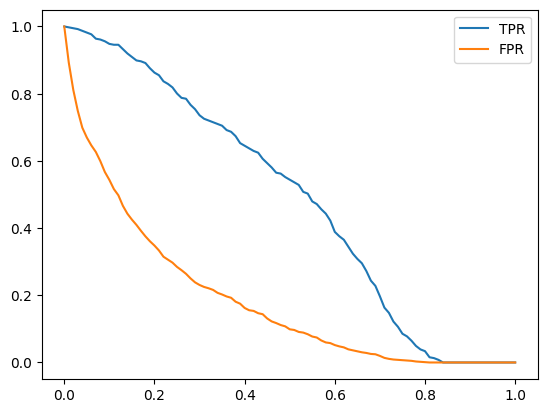

In [32]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

If the threshold is 0 or 1, the FPR and Recall scores are the opposite of the threshold (1 and 0 respectively), but they have different meanings, as we explained before.

We need to compare the ROC curves against a point of reference to evaluate its performance, so the corresponding curves of random and ideal models are required.

### Random model

In [36]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))
y_rand.round(3)

array([0.417, 0.72 , 0.   , ..., 0.774, 0.334, 0.089])

In [37]:
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [38]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [39]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

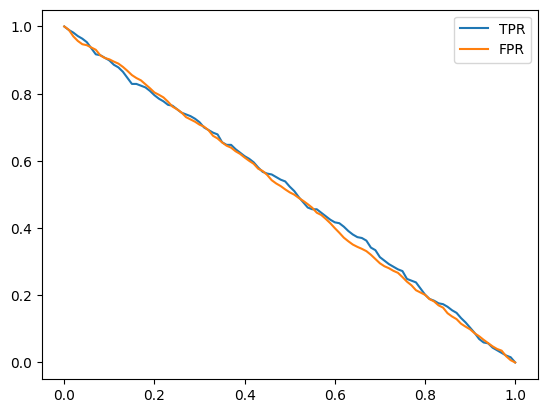

In [40]:
plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
plt.legend()

### Ideal model

In [41]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(1023, 386)

In [43]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])

y_ideal_pred = np.linspace(0, 1, len(y_val))

In [44]:
1 - y_val.mean()

0.7260468417317246

In [45]:
accuracy_score(y_ideal, y_ideal_pred >= 0.726)

1.0

In [46]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,386,882,0,141,1.000000,0.862170
20,0.2,386,741,0,282,1.000000,0.724340
30,0.3,386,600,0,423,1.000000,0.586510
40,0.4,386,459,0,564,1.000000,0.448680
50,0.5,386,319,0,704,1.000000,0.311828
60,0.6,386,178,0,845,1.000000,0.173998
70,0.7,386,37,0,986,1.000000,0.036168
80,0.8,282,0,104,1023,0.730570,0.000000
90,0.9,141,0,245,1023,0.365285,0.000000


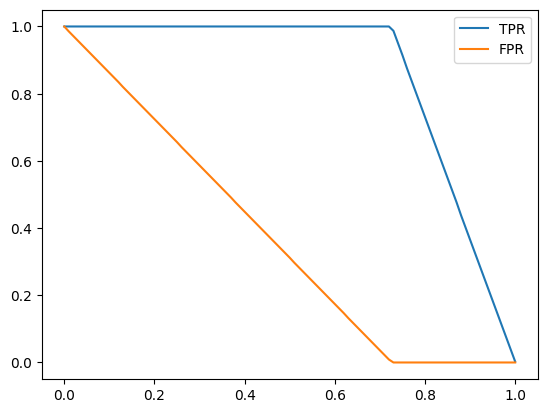

In [47]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')
plt.legend()

### Putting everything together

It is possible to plot the ROC curves with FPR and Recall scores vs thresholds, or FPR vs Recall.

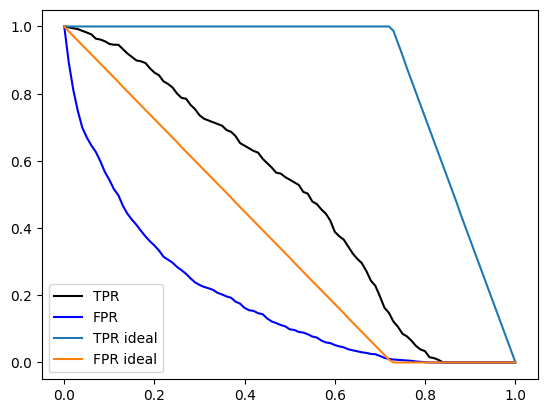

In [48]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR', color='black')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR', color='blue')

plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR ideal')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR ideal')

# plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR random', color='grey')
# plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR random', color='grey')

plt.legend()

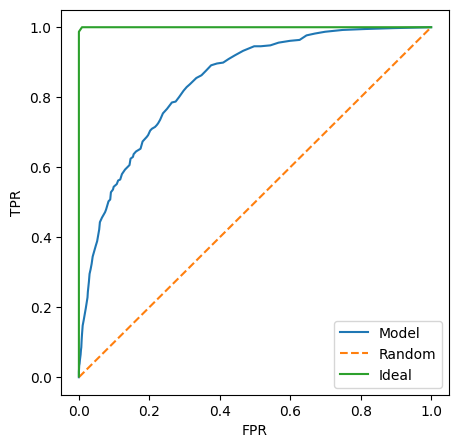

In [52]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')
plt.plot(df_ideal.fpr, df_ideal.tpr, label='Ideal')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

### Plotting ROC curves with scikit-learn

In [53]:
from sklearn.metrics import roc_curve

In [54]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

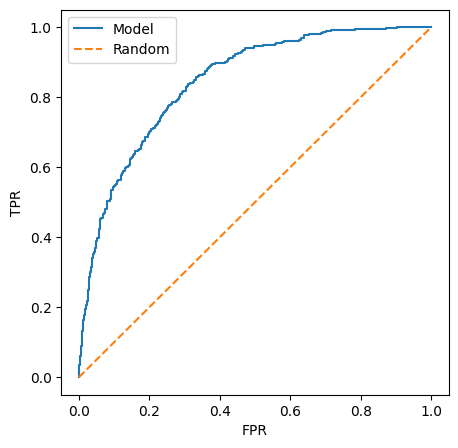

In [55]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

## 6- ROC AUC
* Area under the ROC curve - useful metric
* Interpretation of AUC

## 7- Cross-Validation
* Evaluating the same model on different subsets of data
* Getting the average prediction and the spread within predictions

## 8- Summary
* Metric - a single number that describes the performance of a model
* Accuracy - fraction of correct answers; sometimes misleading
* Precision and recall are less misleading when we have class inbalance
* ROC Curve - a way to evaluate the performance at all thresholds; okay to use with imbalance
* K-Fold CV - more reliable estimate for performance (mean + std)